In [36]:
from enum import Enum
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from os import path

In [37]:
if not path.exists("inputs/avergra2.bmp"):  # avergra = avarage gradient
    !wget https://users.itk.ppke.hu/~horan/avergra2.bmp -P ./inputs/

- Input képek konvertálása a CNN bemeneti tartományára.
- Innvertálni is kell a képeket, mert CNN-en -1 a fehér, 1 a fekete, míg a képeken 0 a fekete, 255 a fehér

Uint8: [0, 255] -> Cell: [-1, 1]

In [38]:
def Uint8ToCell(arr):
    #this function converts an array from unit8, 0-255, oBlack, 255White to -1White, 1Black
    return -1*(arr.astype(np.float) / 127.5 - 1.0)

- Visszakonvertálás kép formátumra.

Cell: [-1, 1] -> Uint8: [0, 255]

In [39]:
def CellToUint8(arr):
    #this function converts an array from -1White, 1Black unit8 to 0-255, oBlack, 255White 
    arr = (arr*(-1)+1)*127.5
    arr = arr.astype(np.uint8)
    return arr 

Nemlineáris fv, ami levágja a kimenetet a [-1, 1] tartományra.
(nemlinearitás/nonlinearitás/dinamika)

In [40]:
def StandardCNNNonliearity(x):
    # this function implements the standard CNN nonlinearity, all values are saturated below -1 and above 1
    back = x
    back[x < -1] = -1
    back[x > 1] = 1
    return back

# Peremfeltételek nélküli él detekció 
(csökkentett területen, a szélek nélkül fut a szimuláció)

In [41]:
class BoundaryType(Enum):
    Fixed = 1
    ZeroFlux = 2
    Periodic = 3

class CellSim:
    def __init__(self):
        self.Input = []
        self.State = []
        self.Output = []
        self.A = np.zeros((3,3))
        self.B = np.zeros((3,3))
        self.Z = 0
        self.SimTime = 1
        self.TimeStep = 0.1
        self.OutputNonlin = StandardCNNNonliearity
        self.Boundary = BoundaryType.Fixed
        self.BoundValue = 0

    def SetInput(self,In):
        self.Input = Uint8ToCell(cv2.cvtColor(cv2.imread(In), cv2.COLOR_BGR2GRAY))

    def SetState(self,St):
        self.State = Uint8ToCell(cv2.cvtColor(cv2.imread(St), cv2.COLOR_BGR2GRAY))

    def Euler(self,f,y0,StartTime,EndTime,h):
        t,y = StartTime,y0
        i = 0
        while t < EndTime:
            t += h
            y += h * f(t,y)
            i += 1
        print(i)
        return y

    def Simulate(self):
        Ret = self.Euler(self.cell_equation,self.State.flatten(),0, self.SimTime,0.1)
        SizeX = self.State.shape[0]
        SizeY = self.State.shape[1]
        OutImg = self.OutputNonlin(np.reshape(Ret,[SizeX,SizeY]))
        return OutImg

    def cell_equation(self,t,X):
        # This function impelment the differential equation determining the standard cnn cell:
        # xdot = -x + Ay + Bu + z
        # The parameters of the CNN array (templates) are stored in P
        # Reshape the 1xN input for the size of the image (ode solvers can only deal with vectors but code is more understandable if we use arrays)
        SizeX = self.State.shape[0]
        SizeY = self.State.shape[1]
        x = np.reshape(X,[SizeX,SizeY])
        # We will return the derivative in this array
        dx = np.zeros((SizeX,SizeY))

        # Go through all elements of the array
        for a in range(SizeX):
            for b in range(SizeY):
                if a == 0 or b == 0 or a == (SizeX-1) or b == (SizeY-1):
                    input_region = np.zeros((3,3))
                    state_region = np.zeros((3,3))
                    for c in range(-1, 2):
                        for d in range (-1, 2):
                            if self.Boundary == BoundaryType.Fixed:
                                if a+c < 0 or b+d < 0 or a+c > (SizeX-1) or b+d > (SizeY-1):
                                    input_region[c+1, d+1] = self.BoundValue
                                    state_region[c+1, d+1] = self.BoundValue
                                else:
                                    input_region[c+1, d+1] = self.Input[a+c, b+d]
                                    state_region[c+1, d+1] = x[a+c, b+d]
                            elif self.Boundary == BoundaryType.ZeroFlux:
                                ind_a = a+c
                                if a+c < 0:
                                    ind_a = 0
                                elif a+c > SizeX-1:
                                    ind_a = SizeX -1

                                ind_b = b+d
                                if b+d < 0:
                                    ind_b = 0
                                elif b+d > SizeY-1:
                                    ind_b = SizeY -1

                                input_region[c+1, d+1] = self.Input[ind_a, ind_b]
                                state_region[c+1, d+1] = x[ind_a, ind_b]
                            elif self.Boundary == BoundaryType.Periodic:
                                ind_a = a+c
                                if a+c < 0:
                                    ind_a = SizeX-1
                                elif a+c > SizeX-1:
                                    ind_a = 0

                                ind_b = b+d
                                if b+d < 0:
                                    ind_b = SizeY-1
                                elif b+d > SizeY-1:
                                    ind_b = 0

                                input_region[c+1, d+1] = self.Input[ind_a, ind_b]
                                state_region[c+1, d+1] = x[ind_a, ind_b]
                else:
                    input_region = self.Input[a-1:a+2, b-1:b+2]
                    state_region = x[a-1:a+2, b-1:b+2]

                output_region = self.OutputNonlin(state_region)
                forward_coupling = np.sum(np.multiply(self.B, input_region))
                feedback_coupling = np.sum(np.multiply(self.A, output_region))
                dx[a,b] = -x[a,b] + feedback_coupling + forward_coupling + self.Z

        #reshape back to Nx1
        dx = np.reshape(dx,[SizeX*SizeY])
        return dx

**Élkereső template**

51


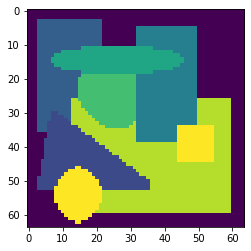

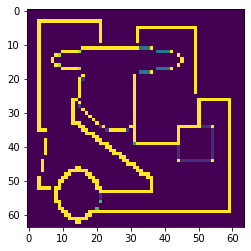

In [42]:
CNN=CellSim() #intialization of the simulator

CNN.TimeStep = 0.1 #setting the timestep of the numerical solution
CNN.SimTime = 5.0 #setting the running time of the simulation
CNN.A = [[0, 0, 0],[0, 1.0, 0],[0, 0, 0]]  #defining the values of the A template
CNN.B = [[-1.0, -1.0, -1.0],[-1.0, 8, -1.0],[-1.0, -1.0, -1.0]] #defining the values of the B template
CNN.Z = -1.0 #Bias
CNN.SetInput('inputs/avergra2.bmp')  #loading the input image
CNN.SetState('inputs/avergra2.bmp')  #loading the initial state
CNN.Boundary = BoundaryType.ZeroFlux  #setting the  Boundary condition

OutImg = CNN.Simulate() #executing the simulation, the function returns the output image of the CeNN array
plt.imshow(CNN.Input) #displaying the input image
plt.figure()
plt.imshow(OutImg) #displaying the output image

**Treshold template 0.4-es intenzitással**

51


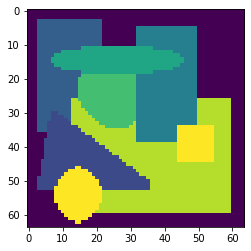

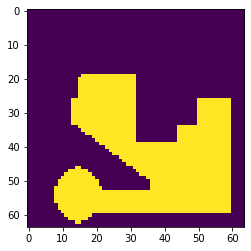

In [43]:
CNN=CellSim()

CNN.TimeStep = 0.1
CNN.SimTime = 5.0
CNN.A = [[0, 0, 0],[0, 2.0, 0],[0, 0, 0]]
CNN.B = [[0, 0, 0],[0, 0, 0],[0, 0, 0]]
CNN.Z = -0.4
CNN.SetInput('inputs/avergra2.bmp')
CNN.SetState('inputs/avergra2.bmp')
CNN.Boundary = BoundaryType.Fixed

OutImg = CNN.Simulate()
plt.imshow(CNN.Input)
plt.figure()
plt.imshow(OutImg)

Mentsük ki az eredményt képként

In [44]:
out_treshold = CellToUint8(OutImg)

img = Image.fromarray(out_treshold)
img.save("outputs/avergra2_treshold.bmp", "BMP")

**Dilation template**

In [45]:
CNN=CellSim()

CNN.TimeStep = 0.1
CNN.SimTime = 5.0
CNN.A = [[0, 0, 0],[0, 0, 0],[0, 0, 0]]
CNN.B = [[0, 0, 0],[1.0, 1.0, 0],[0, 1.0, 0]]
CNN.Z = 2

# A kezdeti állapot tetszőleges
# Teljesen fekete kép kezdeti állapotnak
letterA = cv2.cvtColor(cv2.imread("inputs/A_letter.BMP"), cv2.COLOR_BGR2GRAY)
letterA = np.zeros(letterA.shape)
letterA[:] = -1
# Teljesen fehér kép kezdeti állapotnak
# letterA[:] = 1

CNN.SetInput('inputs/A_letter.BMP')
CNN.State = letterA
# Eredeti kép kezdeti állapotnak
# CNN.SetState('A_letter.BMP')
CNN.Boundary = BoundaryType.ZeroFlux

OutImg = CNN.Simulate()
plt.imshow(CNN.Input)
plt.figure()
plt.imshow(OutImg)

KeyboardInterrupt: 

Mentsük ki az eredményt képként

In [ ]:
out_dilation = CellToUint8(OutImg)

img = Image.fromarray(out_dilation)
img.save("outputs/A_letter_dilation.BMP", "BMP")


**Shadow projection/Leftshadow template**

In [ ]:
CNN=CellSim()

CNN.TimeStep = 0.1
# Ennek több iteráció kell
CNN.SimTime = 100.0
CNN.A = [[0, 0, 0],[0, 2.0, 2.0],[0, 0, 0]]
CNN.B = [[0, 0, 0],[0, 2.0, 0],[0, 0, 0]]
CNN.Z = 0 # Bias

# A kezdeti állapot teljesen fehér
conc = cv2.cvtColor(cv2.imread("inputs/CONC2.bmp"), cv2.COLOR_BGR2GRAY)
conc_input = np.zeros(conc.shape)
conc_input[:] = 1.0

CNN.SetInput('inputs/CONC2.bmp')
CNN.State = conc_input
CNN.Boundary = BoundaryType.Fixed

OutImg = CNN.Simulate()
plt.imshow(CNN.Input)
plt.figure()
plt.imshow(OutImg)

Mentsük ki az eredményt képként

In [ ]:
out_leftshadow = CellToUint8(OutImg)

img = Image.fromarray(out_leftshadow)
img.save("outputs/CONC2_leftshadow.BMP", "BMP")

**FillGray template**

In [ ]:
CNN=CellSim()

CNN.TimeStep = 0.1
CNN.SimTime = 10.0
CNN.A = [[0, 0, 0],[0, 0, 0],[0, 0, 0]]
CNN.B = [[0, 0, 0],[0, 0, 0],[0, 0, 0]]
CNN.Z = 0 # Bias

# A kezdeti állapot és az input is tetszőleges
CNN.SetInput('inputs/CONC2.bmp')
CNN.SetState('inputs/CONC2.bmp')
CNN.Boundary = BoundaryType.Fixed

OutImg = CNN.Simulate()
plt.imshow(CNN.Input)
plt.figure()
plt.imshow(OutImg)

Ahogy az OutImg plotján látszik, úgy tűnik mintha nem kaptunk volna szürke képet, de ez csak azért van, mivel a plot különbség térkép, vagyis az értékkészlethez méri a színeket. És mivel a képen minden nulla nulla marad, és minden más egyenletesen konvergál 0-hoz, így még kis különbség is az eredeti képnek látszik. Ha azonban átváltjuk a CNN kimenetét képpé, és ezt kiíratjuk, ábrázoljuk, akkor látszik, hogy minden pixel értéke 127, vagyis középszürke.

In [ ]:
gray_img = CellToUint8(OutImg)
print(gray_img[20, :])
plt.imshow(gray_img)